In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import joypy
from scipy import signal

# Set font sizes for plots
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('font', size=MEDIUM_SIZE)

#colors
colors_gwl=['black',(253/255, 141/255, 60/255),(189/255, 0/255, 38/255)]

# Global warming levels
years = np.linspace(1850, 2100, 251)
Tglob = ["T0","T15","T27"]
Tglob_values = [0,1.5,2.7]

# Data path
data_path = '/work/uo1075/u241297/data/large_ensembles/CMIP6/MPI-ESM1-2-LR/'

# Global warming levels

In [2]:
path = data_path+'global-mean/'

# Load global-mean surface air temperature (GSAT) data
GSAT = np.zeros((50, 251))
for i in range(50):
    file = path + "tas_hist_ssp585_r" + str(i + 1) + "_global-mean.nc"
    GSAT[i, :] = np.squeeze(xr.open_dataset(file)['tas']) - 273.15

GSAT_rm = np.array(pd.DataFrame(GSAT).rolling(20, axis=1, center=True).mean())
Tzero_GSAT = np.mean(GSAT[:, 0:51])  # 1850-1900
GSATa = GSAT - Tzero_GSAT
GSATa_rm = GSAT_rm - Tzero_GSAT

In [3]:
# Determine the indices where GSAT crosses the global warming levels
GWLcross_ind = {T: np.empty(50, dtype=int) for T in Tglob}
GWLcross_ind["T0"] = 50 * [20]

for T in range(1, 3):
    for i in range(50):
        j = 20
        while GSATa_rm[i, j] < Tglob_values[T]:
            j += 1
        GWLcross_ind[Tglob[T]][i] = j

GWL_ind = {T: np.zeros((50, 20), dtype=int) for T in Tglob}

for T in range(3):
    for i in range(50):
        GWL_ind[Tglob[T]][i, :] = np.arange(GWLcross_ind[Tglob[T]][i] - 10, GWLcross_ind[Tglob[T]][i] + 10)

# Daily Arctic temperatures

In [4]:
# Load grid cell area
gridarea = np.array(xr.open_dataset(data_path+'gridarea.nc')['cell_area'])

# Load spatial daily surface air temperature (SAT)
ASATday = np.zeros((50, 251, 365, 13, 192))
for i in range(50):
    file = data_path + "arctic/tas_hist_ssp585_r"+str(i+1)+"_arctic.nc"
    ASATday[i, :, :] = np.array(xr.open_dataset(file)['tas']).reshape((251, 365, 13, 192)) - 273.15

# Create GWL samples of Arctic SAT
ASATday_samples = {Tglob[T]: [ASATday[i, GWL_ind[Tglob[T]][i, :], :, :, :] for i in range(50)] for T in range(3)}

# Free up space
del ASATday

In [5]:
# Detrend by subtracting linear trend of ensemble mean

# Ensemble mean
ASATday_ensmean_samples = {T: np.nan_to_num(np.mean(ASATday_samples[T], axis=0)) for T in Tglob}

# Daily trend
ASATday_trend_samples = {T: ASATday_ensmean_samples[T] - signal.detrend(ASATday_ensmean_samples[T], axis=0) - np.mean(ASATday_ensmean_samples[T], axis=0, keepdims=True) for T in Tglob}

# Daily detrended
ASATday_detrend_samples = {T: ASATday_samples[T] - ASATday_trend_samples[T][np.newaxis, :, :, :, :] for T in Tglob}

In [6]:
# Compute (area-weighted) Arctic mean
ASATday_detrend_arcticmean_samples = {Tglob[T]: np.average(ASATday_detrend_samples[Tglob[T]].reshape(50, 20, 365, 13 * 192), axis=3, weights=np.ravel(gridarea)) for T in range(3)}


In [7]:
# Create seasonal samples

ASATday_detrend_arcticmean_seasonal_samples = {season: {} for season in ["DJF", "MAM", "JJA", "SON"]}
for T in range(3):
    ASATday_detrend_arcticmean_seasonal_samples["DJF"][Tglob[T]] = np.append(ASATday_detrend_arcticmean_samples[Tglob[T]][:,:,-31:], ASATday_detrend_arcticmean_samples[Tglob[T]][:,:,:59],axis=2)                                                                 
    ASATday_detrend_arcticmean_seasonal_samples["MAM"][Tglob[T]] = ASATday_detrend_arcticmean_samples[Tglob[T]][:,:,59:151]
    ASATday_detrend_arcticmean_seasonal_samples["JJA"][Tglob[T]] = ASATday_detrend_arcticmean_samples[Tglob[T]][:,:,151:243]                                                                  
    ASATday_detrend_arcticmean_seasonal_samples["SON"][Tglob[T]] = ASATday_detrend_arcticmean_samples[Tglob[T]][:,:,243:334]                                                                                                                                                                                             

In [8]:
# Compute anomalies

seasons = ["DJF", "MAM", "JJA", "SON"]
season_lengths = {"DJF": 90, "MAM": 92, "JJA": 92, "SON": 91}

ASATday = np.zeros((50, 251, 365))
ASATday_seasonal = {season: np.zeros((50, 251, season_lengths[season])) for season in seasons}

# Load Arctic mean temperatures
for i in range(50):
    file = data_path + "arctic-mean/tas_hist_ssp585_r"+str(i+1)+"_arctic-mean.nc"
    with xr.open_dataset(file) as ds:
        ASATday[i, :, :] = ds['tas'].values.reshape((251, 365)) - 273.15
    
    for season in seasons:
        file = data_path + "arctic-mean/tas_hist_ssp585_r"+str(i+1)+"_arctic-mean_" +str(season) +".nc"
        with xr.open_dataset(file) as ds:
            ASATday_seasonal[season][i, :, :] = ds['tas'].values.reshape((251, season_lengths[season])) - 273.15

# Compute anomaly reference
Tzero_ASATday = np.mean(ASATday[:, 0:51, :])
Tzero_ASATday_seasonal = {season: np.mean(ASATday_seasonal[season][:, 0:51, :]) for season in seasons}

# Compute anomalies for GWL samples
ASATaday_detrend_arcticmean_samples = {Tglob[T]: ASATday_detrend_arcticmean_samples[Tglob[T]] - Tzero_ASATday for T in range(3)}
ASATaday_detrend_arcticmean_seasonal_samples = {
    season: {Tglob[T]: ASATday_detrend_arcticmean_seasonal_samples[season][Tglob[T]] - Tzero_ASATday_seasonal[season] for T in range(3)}
    for season in seasons
}

# Free up space
del ASATday, ASATday_seasonal

In [9]:
# Remove seasonal cycle

# Compute seasonal cycle
ASATaday_detrend_arcticmean_SC_samples = {
    Tglob[T]: np.mean(ASATaday_detrend_arcticmean_samples[Tglob[T]], axis=(0, 1))
    for T in range(3)
}
ASATaday_detrend_arcticmean_SC_seasonal_samples = {
    season: {
        Tglob[T]: np.mean(ASATaday_detrend_arcticmean_seasonal_samples[season][Tglob[T]], axis=(0, 1))
        for T in range(3)
    }
    for season in ["DJF", "MAM", "JJA", "SON"]
}

# Subtract seasonal cycle
ASATaday_detrend_arcticmean_deseasonalized_samples = {
    Tglob[T]: ASATaday_detrend_arcticmean_samples[Tglob[T]] - ASATaday_detrend_arcticmean_SC_samples[Tglob[T]][np.newaxis, np.newaxis, :] + np.mean(ASATaday_detrend_arcticmean_samples[Tglob[T]])
    for T in range(3)
}
ASATaday_detrend_arcticmean_deseasonalized_seasonal_samples = {
    season: {
        Tglob[T]: ASATaday_detrend_arcticmean_seasonal_samples[season][Tglob[T]] - ASATaday_detrend_arcticmean_SC_seasonal_samples[season][Tglob[T]][np.newaxis, np.newaxis, :] + np.mean(ASATaday_detrend_arcticmean_seasonal_samples[season][Tglob[T]])
        for T in range(3)
    }
    for season in ["DJF", "MAM", "JJA", "SON"]
}

# PDF plots

In [10]:
seasons = ['annual', 'DJF', 'MAM', 'JJA', 'SON']

# Create DataFrames for each season
dfs = []
for season in seasons:
    if season == 'annual':
        data = ASATaday_detrend_arcticmean_deseasonalized_samples
    else:
        data = ASATaday_detrend_arcticmean_deseasonalized_seasonal_samples[season]
    
    df = pd.DataFrame({
        'T0': np.ravel(data["T0"]),
        'T15': np.ravel(data["T15"]),
        'T27': np.ravel(data["T27"]),
        'Data': season
    })
    dfs.append(df)

# Concatenate all DataFrames
df = pd.concat(dfs)
df_grouped = df.groupby('Data', sort=False)

<Figure size 640x480 with 0 Axes>

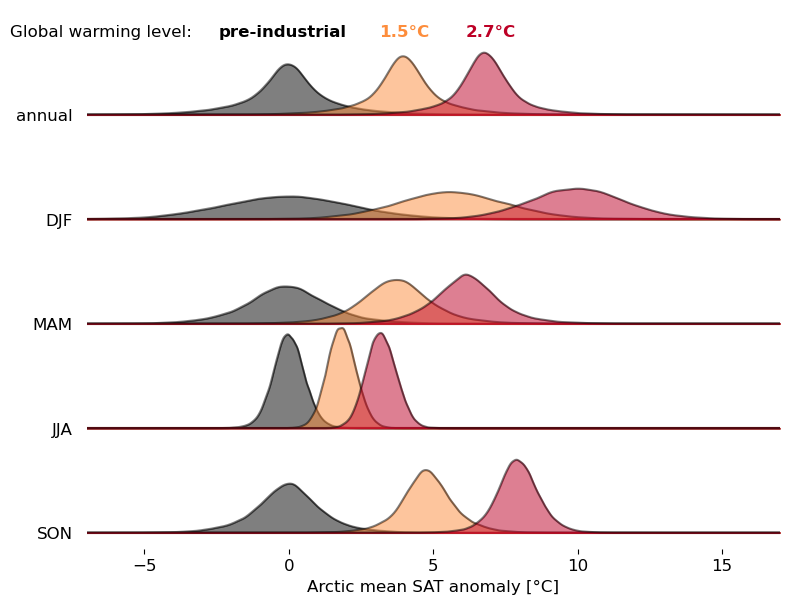

In [11]:
# Draw Plot
plt.figure()
fig, axes = joypy.joyplot(df_grouped,
    column=['T0','T15','T27'],
    by='Data',
    x_range=[-7,17],
    color=colors_gwl,
    overlap=0.2,
    alpha=0.5,
    figsize=(8,6))

# Add text annotations
plt.text(-6.5, 0.95, 'Global warming level:', ha='center', color='black', fontsize=12)
plt.text(-0.2, 0.95, 'pre-industrial', ha='center', color=colors_gwl[0], fontsize=12, fontweight='bold')
plt.text(4, 0.95, '1.5°C', ha='center', color=colors_gwl[1], fontsize=12, fontweight='bold')
plt.text(7, 0.95, '2.7°C', ha='center', color=colors_gwl[2], fontsize=12, fontweight='bold')

plt.xlabel('Arctic mean SAT anomaly [°C]')

plt.show()